# Outlier Detection in Sensor Data using Functional Depth Measures

In [3]:
suppressMessages(library(MASS))
suppressMessages(library(tidyverse))
suppressMessages(library(shiny))
suppressMessages(library(shinydashboard))
suppressMessages(library(largeList))
suppressMessages(library(parallel))
suppressMessages(library(Rcpp))
suppressMessages(library(repr))

options(repr.plot.width=30, repr.plot.height=8)

# suppressMessages(library(gganimate)) #needed only to generate the gifs

source("auxiliary/observation_vis.R")
source("auxiliary/distribution_vis.R")
source("auxiliary/updating_vis.R")
source("auxiliary/generate_set_1.R")
source("auxiliary/generate_set_2.R")
source("auxiliary/generate_set_3.R")

sourceCpp('auxiliary/rcpp_functions.cpp')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


## Table of Contents
1. [Introduction](#introduction)
2. [Observation Structure](#observation)
3. [The Algorithm](#algorithm)
4. [h-modal depth](#h-modal)
5. [Difficulties due to the Data](#difficulties)
6. [Sampling Approach](#sampling)
7. [Finding Comparable Sets of Observations](#comparables)
8. [Description of Full Procedure for existing Data sets](#procedure)
9. [Updating](#updating)
10. [Implementation](#implementation)
    1. [Grid Approximation](#impl_grid) 
    2. [Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) for Observations on a Shared Grid](#impl_algorithm)
    3. [Sampling Approach](#impl_sampling)
11. [Simulated Data](#simulated)


## Introduction <a name="introduction"></a>
---
This project is part of a cooperation with **Daimler AG** and deals with outlier detection in sensor data from production processes. <br>
One example of data like this is the relation of angle and torque during the process of tightening a bolt in a screwing connection. This data set will be called "Endanzugsproblem" in the following notebook and contains ~350000 observations of what can be imagined as a function that maps angles to torque. The following schematic will give an idea of what the data set represents and what the problem is:

<img src="material/SchraubdatenPrinzipskizze.png">

To clarify some things about this simplified schematic:
* The so called Enganzug is only part of the tightening process, but the parts of the observation happening before it are not subject of this analysis.
* The focus of this project lies on curves that are "In Ordnung", so observations that do not immediately disqualiy themselves in some way or other by for example not reaching the fixed window of acceptable final values.
* The observations typically have a high frequency of measuring torque but the measuring points are not equidistant
* The angles where torque is measured are not shared between observations, but the measuring interval of angles might overlap between observations
* The Endanzug does not start at the same angle for every observation and also does not necessarily start at the same torque
* Outliers can be very general, so methods based on detecting only specific types of outliers may not be able to effectively filter out other suspicious observations. So optimally we would like to have some kind of Omnibus test for outliers.

Especially due to the high frequency of measurement and the non-identical points where torque is measured the idea of interpreting each observation as a function and therefore approaching the problem from a standpoint of functional data analysis comes to mind. One method that is used in functional data analysis to identify outliers is based on what is called a "functional depth measure". Gijbels and Nagy (2017) introduces the idea of depth as follows and then elaborate on the theoretical properties a depth function for functional data should possess.

> For univariate data the sample median is well known
to be appropriately describing the centre of a data
cloud. An extension of this concept for multivariate
data (say p-dimensional) is the notion of a point (in
$\mathbb{R}^p$) for which a statistical depth function is maximized. 

The idea is to define an analogous concept to centrality measures (such as the distance from some central tendency such as the median) in a scalar setting for functional data and then use those to determine which functions in a set are typical in some sense for the whole population. Due to the more applied nature of this project, I will not go into detail on the theoretical properties of the methods used, but focus on giving intuition why the chosen methods make sense in this context.

The main inspiration for my approach to the problem of detecting outliers in a data set such as the one described above is the paper "Outlier detection in functional data by depth measures, with application to identify abnormal NOx levels" by Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008). I am going to first describe their algorithm, then present my implementation and finally apply it to a simulated data set mimicking the "Endanzugsproblem" as the original data is property of Daimler AG, which I cannot make public.

## Observation Structure <a name="observation"></a>
---
For the sake of clarity, I will show the typical structure of one observation and define a couple of objects I will refer to later.

<img src="material/observation.png" width="1000" align="center">

| Observation 	| 1    	| 2    	| 3    	| 4    	| 5    	| 6    	| 7    	| 8    	| 9    	| 10   	| 11   	| 12   	| 13   	| 14   	| 15   	| 16   	| 17   	| 18   	| 19   	| 20   	|
|:-----------:	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|
|    Angle    	| 2.01 	| 2.21 	| 2.91 	| 3.00 	| 3.07 	| 3.95 	| 4.33 	| 4.35 	| 4.41 	| 4.74 	| 4.77 	| 5.06 	| 6.33 	| 6.37 	| 6.41 	| 6.57 	| 7.25 	| 7.32 	| 7.71 	| 7.94 	|
|    Torque   	| 2.02 	| 2.61 	| 3.05 	| 3.16 	| 2.99 	| 4.19 	| 4.24 	| 4.37 	| 4.73 	| 4.89 	| 5.03 	| 5.45 	| 6.32 	| 6.18 	| 6.22 	| 7.06 	| 7.30 	| 7.59 	| 7.99 	| 8.06 	|

This shows what one observation of the data set might look like.
* The red diamonds represent measurements of torque that were taken at a recorded angle.
* The blue lines are an example of **linear interpolation** which will become important later on.
* The **measuring interval** marked in green is the convex hull of angles where measurements were taken for this observation.

The data set contains many of these objects, that do not necessairly share these characteristics.

In [38]:
# Generated using function from auxiliary/observation_vis.R
# source("auxiliary/observation_vis.R")
# obs_vis()

## The Algorithm <a name="algorithm"></a>
---
The idea of Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) is an iterative process that classifies observations as outliers if their functional depth lies below a threshold C, which is determined using a bootstrapping procedure in each iteration. The algorithm can be decomposed into two parts:

1. **The iterative process**: (quoted from Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008))
    1. Obtain the functional depths $D_n(x_i),\: \dots \: ,D_n(x_n)$ for one of the functional depths [...]
    2. Let $x_{i_1},\: \dots,\: x_{i_k}$ be the k curves such that $D_n(x_{i_k}) \leq C$, for a given cutoff $C$. Then, assume that $x_{i_1},\: \dots,\: x_{i_k}$ are outliers and delete them from the sample.
    3. Then, come back to step 1 with the new dataset after deleting the outliers found in step 2. Repeat this until no more outliers are found. 
    
    <br>
2. **Determining C**: (quoted from Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008))
    1. Obtain the functional depths $D_n(x_i),\: \dots ,\:D_n(x_n)$ for one of the functional depths [...]
    2. Obtain B standard bootstrap samples of size n from the dataset of curves obtained after deleting the $\alpha \%$ less deepest curves. The bootstrap samples are denoted by $x_i^b$ for $i = 1,\: \dots,\: n$ and $b = 1,\: \dots,\: B$.
    3. Obtain smoothed bootstrap samples $y_i^b = x_i^b + z_i^b$, where $z_i^b$ is such that $(z_i^b(t_1), \dots, z_i^b(t_m))$ is normally distributed with mean 0 and covariance matrix $\gamma\Sigma_x$ where $\Sigma_x$ is the covariance matrix of $x(t_1),\: \dots,\: x(t_m)$ and $\gamma$ is a smoothing parameter. Let $y_i^b$, $i = 1,\: \dots,\:n$ and $b = 1,\:\dots,\: B$ be these samples. *
    4. For each bootstrap set $b = 1,\:\dots,\:B$, obtain $C^b$ as the empirical 1% percentile of the distribution of the depths $D(y_i^b)$, $i = 1,\: \dots,\: n$.
    5. Take $C$ as the median of the values of $C^b$, $b = 1,\: \dots,\: B$. 
<br>
*At this point we assume that our functional observations are observed at a set of discrete points $t_1,\:\dots,\:t_m$.

To clarify some things, that might get lost in these quotes:
* n is not constant over the iterative process, which might be counterintuitive in the context of other methods
* As a consequence: while approximating C the set of observations used is not constant over the iterative process either, as the outliers that have been removed are no longer under consideration for the bootstrap procedure

The authors propose three functional depth measures and benchmark them in a simulation setting. Because of their results and the computational cost which are comparatively small, I chose to use **h-modal depth** for my implementation, which I will introduce in the following.

## h-modal depth <a name="h-modal"></a>
---

Introduced by Cuevas, Febrero-Bande, and Fraiman (2006) h-modal depth is one of three depth measures covered in Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008). I will follow the summary in the latter paper for my overview.  <br>The idea behind this depth is that a curve is central in a set of curves if it is closely surrounded by other curves?" <br>

In mathematical terms the h-modal depth of a curve $x_i$ in relation to a set of curves $x_1, \dots, x_n$ is defined as follows: <br>
\begin{equation}
    MD_m(x_i,h) = \sum_{k = 1}^{n} K(\frac{||x_i - x_k||}{h})
\end{equation}

where $K: \mathbb{R^{+}} \rightarrow \mathbb{R^{+}}$ is a kernel function and $h$ is a bandwidth. <br>
The authors recommend using the truncated Gaussian kernel, which is defined as follows:
\begin{equation}
    K(t) = \frac{2}{\sqrt{2\pi}} \exp(-\frac{t^2}{2})
\end{equation}

and to choose $h$ as the 15th percentile of the empirical distribution of $\{||x_i - x_k|| \, ; \, i,k = 1,\:\dots,\:n\}$

I chose to implement the $L^2$ norm - one of the norms recommended by the authors - as it performed better than the $L^{\infty}$ norm (which was also recommended) in my preliminary tests. In a functional setting $L^2$ is defined by:
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\int_a^b (x_i(t) - x_k(t))^2 dt}
\end{equation}

where a and b are the boundaries of the measurement interval. This can be replaced by its empirical version
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\sum_{j = 1}^m (x_i(t_j) - x_k(t_j))^2}
\end{equation}

in case of a discrete set of $m$ observation points shared between observations.

## Difficulties due to the Data <a name="difficulties"></a>
---
### The Endanzug does not start at the same angle for every observation. <br>
In this specific setting this is not much of a problem, as the specific angle where the "Endanzug" starts is not of importance. So all observations can be modified by subtracting the first angle of the "Endanzug" from all angles, effectively **zeroing** the observations.

<img src="material/zero.gif" width="1000" align="center">

### After zeroing, the measurement intervals might still not be identical due to differing lengths. <br>
We can define a parameter $\lambda \geq 1$ that I call **acceptable stretching** and make observations comparable by stretching their measuring intervals by a factor $\psi_i \in [1/\lambda, \lambda]$ before approximating them using linear interpolation. If zeroing as described in 1. is not appropriate a combination of acceptable stretching and acceptable shifting could be implemented to increase the size of sets of pairwise comparable functions.

<img src="material/stretch.gif" width="1000" align="center">

As you can already see in this animation, the acceptable stretching introduces inaccuracies even in an approximately linear setting. Outlier classifications could be quite sensitive to this parameter.

### The angles where torque is measured are not shared between observations. <br>
Assuming that the measuring intervals are identical, we can use **linear interpolation** to approximate the observations and to make them compatible with the simplification described above. This is only an approximation, but choosing an appropriately fine grid to approximate the observations should limit the influence of this procedure on the calculated functional depths.

<img src="material/grid_approx.gif" width="1000" align="center">

Another possibility to approach this third problem would be to use a different version of the norm for discretized points I described above. <br>
Instead of calculating 
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\sum_{j = 1}^m (x_i(t_j) - x_k(t_j))^2}
\end{equation}

one could instead define functions $\tilde{x}_i$ which are just the piecewise linear functions defined by connecting the observed points of $x_i$. A norm based on this could be constructed as:

\begin{equation}
    ||x_i - x_k||_{\tilde{2}} = \sqrt{\int_a^b (\tilde{x}_i(t) - \tilde{x}_k(t))^2 dt}
\end{equation}

For very fine grid approximations these criteria should result in similar depths, as in practice the second approach should be proportional to the limit of the first with an increasingly fine grid. <span style="color:red"> BESSER BEGRÜNDEN</span>.

### Runtime Complexity <br>
The runtime complexity of this algorithm is at least $O(n^2)$ and I concluded that using my implementation it is infeasible use it on a very large data set such as the "Endanzugsproblem" (assuming that all observations are comparrable at once). Even when splitting up the observations as proposed above into comparable subsets, some of them will be too large to directly approach with this method. <br>
To solve this problem I instead opted to use a **sampling approach**.

In [39]:
### The gifs have been rendered using function from auxiliary/observation_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/observation_vis.R")
# stretching_vis()
# zeroing_vis()
# lin_approx_vis()

## Sampling Approach <a name="sampling"></a>
---
Since it is infeasible to use this method on very large data sets at once, I instead made the assumption that observations that would be classified as outliers in the overall set will also be classified as outliers in subsets of the data set more frequently. So instead of performing the algorithm described above on the whole data set (or its comparable subsets), I chose to instead follow the following approach: <br>

Let $\{x_1, \dots, x_L\}$ be a set of observations that are comparable using the algorithm but too large to perform this procedure in reality.
1. Define the following objects:
    * Let *num\_samples* $ = (a_1,\:\dots,\: a_L) \in \mathbb{N}_0^L$ where $a_i$ is the number of samples $x_i$ was part of $\quad \forall i \in \{1,\:\dots,\: L\}$. <br>(Initialize all entries as 0)
    * Let *num\_outliers* $ = (b_1,\:\dots,\: b_L) \in \mathbb{N}_0^L$ where $b_i$ is the number of samples $x_i$ was classified as an outlier in $\quad \forall i \in \{1,\:\dots,\: L\}$. <br>(Initialize all as entries 0)
    * Let *frac\_outliers* $ = (c_1,\:\dots,\: c_L) \in \mathbb{R}_{\geq 0}^L$ where $c_i = \begin{cases}1 & a_i = 0 \\ \frac{b_i}{a_i} & a_i > 0\end{cases} \quad \forall i \in \{1,\:\dots,\: L\}$  <br>(Initialize all entries as 1)
2. Draw a sample of size K from $\{x_1,\: \dots,\: x_L\}$.    <span style="color:red"> MIT REPLACEMENT ODER OHNE???</span>.
3. Perform the outlier detection procedure on this sample and update the vectors accorrding to your results.
4. Go back to two and iterate this process until some condition is fulfilled.

Typical conditions could be:
* A specified number of iterations was reached
* Every observation was part of more than a specified number of samples
* The vector of certainties did not change enough according to some criterion over a specified number of iterations

In the end, the entries of *frac\_outliers* can be used as a metric for the outlyingness of an observation. If a binary decision rule is needed, every observation with an entry over some specified threshold could be classified as an outlier.

## Finding Comparable Sets of Observations <a name="comparables"></a>
---
Assume for the sake of simplicity that **zeroing** is reasonable so that the minima of the measurement intervals of the observations are all zero. So the measurement intervals are different in their end points (or lengths which is identical in this case). As an example assume that the empirical distribution of endpoints looks as follows:

<img src="material/dist.png" width="1000" align="center">

There are three options for generating comparable subsets that came to my mind:

### Static Splitting

Partition the whole data set into pairwise disjunct subsets of pariwise comparable observations. This partition would depend of the acceptable stretching parameter. Notice that these partitions are not necessarily unique for one acceptable stretching parameter and a choice procedure would have to be introduced if this approach were to be taken. <br>
Some possible partitions of the set above (not necessarily consistent with the same acceptable stretching parameter) could look like this: 

<img src="material/static_splits.gif" width="1000" align="center">

This idea has some problems:
* The choice of subsets could introduce a new source of distortions in addition to the acceptable stretching parameter.
* Adding new observations could change the chosen subsets, making an updating procedure difficult to realize.
* In each individual subset, the observations that are changed due to stretching are identical over samples. This could lead to distortions since for some observations not the original but only the stretched observations are taken into account in the classification.

### Dynamic Splitting

Allocate the comparable subsets dynamically. For each realization of the endpoint determine the subset of comparable observations and perform the sampling approach described above on this subset but keep the parameter for acceptable strertching constant for all end points. This is the variant I chose for my implementation.

<img src="material/dyn_splits.gif" width="1000" align="center">

This approach has some advantages over the first one:
* The choice of subsets becomes only a questing of the acceptable stretching parameter and not of the choice of algorithm that chooses the partition of the data set.
* Adding new observations is unproblematic, as sampling can be done with them at the center. A procedure like this is described in the next section.
* Each observation can enter the classification procedure undistorted in at least the comparable subset corresponding to its own endpoint. Additionally it can enter the classification in samples, where it is comparable due to acceptable stretching. The latter can realize for different degrees of stretching - increasing or decresing the length of the measuring interval. This solves the problem of observations being used for classification only in a specific distorted state.

### Dynamic Splitting with varying acceptable stretching parameter

As shown above, the difference in length of the measurement interval of comparable subsets changes quite substantially and does not react to the density of observations having similar measurement intervals. It would be possible to use an acceptable stretching parameter that changes locally as a function of the estimated density of end points (since zeroing was admissible in this example).
Using a rather simple function determining the local acceptable stretching parameter to serve as an example leads to the following choice of comparable subsets.

<img src="material/dyn_splits2.gif" width="1000" align="center">

In this example the effect is quite subtle, but in comparison to the previous animation, one can see that the expansion of the interval of end points of comparable observations comparable is slower in regions, where the estimated density of end points is higher. <br>
There are two reasons why I decided against making acceptable stretching a varying parameter in my implementation:
1. It introduces another complication as the function to determine the local acceptable stretching has to be chosen.
2. It makes the updating procedure descrribed later more difficult, as adding more observations will change the estimated density of the end points and thereby change the comparable subsets.

In [40]:
### The graphics and gifs have been rendered using function from auxiliary/observation_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/distribution_vis.R")
# dist_vis()
# static_splits_vis()
# dynamic_splits_vis()
# dynamic_splits2_vis()

## Description of Full Procedure for existing Data sets <a name="procedure"></a>
---
Having explained its parts:
* The algorithm by Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008)
* The sampling approach 
* The procedure for selecting comparable subsets with dynamic splitting of the data set 

I am going to explain the full procedure applied to an existing data set assuming that zeroing is admissible. <br>

### Definition of Objects
* Let $x_1,\: \dots,\: x_n$ be the full data set of observations as described in the beginning
* Let $I_1 = [s_1, e_1], \dots, I_n = [s_n, e_n]$ be the measuring intervals of $x_1, \dots, x_n$

Assuming that zeroing is admissible:
* Let $\bar{x}_1,\: \dots, \:\bar{x}_n$ be the corresponding zeroed observations
* Let $\bar{I}_1 = [0, \: \bar{e}_1], \: \dots, \bar{I}_n = [0, \bar{e}_n]$ be the corresponding zeroed measuring intervals
* Let $\bar{E} = \{\bar{e} \: | \: \exists k \in \{1, \dots, n\} \: \text{s.t.} \: \bar{e} = \max(\bar{I}_k)\}$ be the set of measuring interval end points occuring in $\bar{I}_1,\: \dots,\: \bar{I}_n$
* Let $\bar{\Lambda}(\bar{x}, \bar{e})$ be the resulting object when zeroed observation $\bar{x}$ is stretched to fit zeroed measuring interval $\bar{I} = [0, \bar{e}]$

Again assuming that zeroing is admissible, we can use the following objects. 
* Let $\bar{Z}(\bar{e}, \lambda) = \{\bar{x}_k \: | \: \frac{\bar{e}_k}{\bar{e}} \in [\frac{1}{\lambda},\lambda]\}$ be the set of zeroed observations that can be compared to a zeroed observation with measuring interval $\bar{I} = [0, \bar{e}]$ with an acceptable stretching factor of $\lambda$.
* Let $\bar{S}(\bar{e}, \lambda) = \{\bar{\Lambda}(\bar{e}, \bar{x}) \: | \: \bar{x} \in \bar{Z}(\bar{e}, \lambda)\}$ be the set of zeroed observations that have been stretched with an admissible stretching factor to be comparable to a zeroed observation with zeroed measuring interval $\bar{I} = [0, \bar{e}]$.

If zeroing is not a valid approach, we will have to define correspoding objects dependent on acceptable shifting and acceptable stretching.

### Procedure
1. Choose parameters:
    * $\lambda$ acceptable stretching
    * $L$ sample size in sampling procedure (may also be varying depending on chosen approach for sampling)*
    * $K$ number of equidistant points in grid for approximation by linear interpolation*
    * $B$ sample size in estimation of cutoff value $C$ in outlier classification algorithm*
    * $\gamma$ tuning parameter in estimation of cutoff value $C$ in outlier classification algorithm*
2. Initialize the following vectors:
    * *num\_samples* $ = (a_1,\:\dots,\: a_n)\in \mathbb{N}_0^n \quad$ with all entries being 0
    * *num\_outliers* $ = (b_1,\:\dots,\: b_n)\in \mathbb{N}_0^n \quad$ with all entries being 0
    * *frac\_outliers* $ = (c_1,\:\dots,\: c_n) \in \mathbb{R}_{\geq 0}^n \quad$ with all entries being 1
3. Iterate through the elements of $\bar{E}$ in ascending order doing the following:
    * Let $\hat{e}$ be the element of $\bar{E}$ currently looked at
    * Determine $\bar{S}(\hat{e}, \lambda)$ and perform the sampling based outlier identification procedure on this set for some predetermined stopping condition
    * Update *num\_samples*, *num\_outliers*, and *frac\_outliers* for both the stretched and non stretched observations in $\bar{S}(\hat{e}, \lambda)$ as described in the section about sampling
    * Go to the next element of $\bar{E}$ and repeat until all elements have been reached.
4. Report *frac\_outliers* as a measure of outlyingness for the observations.

*not explicitly mentioned in the procedure below


## Updating <a name="updating"></a>
---
The procedure described above is constructed to work for a full data set. In a day to day setting the data set will not be static. Instead new observations will be added and it would be a problem, if all calculations would have to be done all over again only to incorporate a comparatively small number of new observations.

Instead one could devise a mechanism to assign comparable values of *frac\_outliers* to the newly added observations and possibly also update the pre-existing observations due to the presence of the newly added ones. In the following assume that new observations are added sequentially. Two ways came to my mind to approach this updating procedure, one more true to the original process (1) and the other one less computationally expensive (2).

### Version 1:
This procedure insolves additional samples from all sets the new observation could have been part of. So both in a stretched form or in its original form <br>
* Let $x'$ be the new observation and $\bar{x}'$ its zeroed counterpart. Define $I'$, $\bar{I'}$ and $\bar{e}'$ accordingly.
* Determine all elements $\bar{e} \in \bar{E}$ such that $\bar{x}' \in \bar{Z}(\bar{e}, \lambda)$. Define $\bar{U}(\bar{x}', \lambda) = \{\bar{e} \in \bar{E} \: | \: \bar{x}' \in \bar{Z}(\bar{e}, \lambda)\}$ as the subset of $\bar{E}$ called the Updating Window. <br> In this setting where zeroing is admissible, this can be simplified to $\bar{U}(\bar{x}', \lambda) = \{\bar{e} \in \bar{E} \: | \: \bar{e} \in [\frac{1}{\lambda} \bar{e}', \lambda \bar{e}']\} = \bar{E} \cap [\frac{1}{\lambda} \bar{e}', \lambda \bar{e}']$
    
<img src="material/update_1.gif" width="1000" align="center"> 

For all $\tilde{e} \in \bar{U}(\bar{x}', \lambda)$ perform a sampling procedure as follows: <br>
* $\bar{\Lambda}(\bar{x}', \tilde{e})$ is part of each sample 
* The size of each sample is identical to the one used in the original procedure
* The number of samples for each $\tilde{e}$ is the expected value of the number of samples the new observation would have been part of, if it had been in the original data set
* The updating procedure works as before. Not only the entry of the new observation in each vector is added and updated, also the entries for the original observations are updated.

So the set of zeroed observations that is potentially updated during this procedure is the following: <br> 
$$\bigcup_{\tilde{e}\in \bar{U}(\bar{x}', \lambda)} \bar{Z}(\tilde{e}, \lambda) = \Big\{\bar{x} \: | \: \bar{e} \in \big[\frac{1}{\lambda}\min\{\bar{U}(\bar{x}', \lambda)\}, \lambda \max\{\bar{U}(\bar{x}', \lambda)\}\big]\Big\}$$
<br>
Which is visualized in the following animation. (The endpoints of the potentially updated zeroed observations are marked by the red rectangle.)

<img src="material/update_2.gif" width="1000" align="center"> 
 

        
### Version 2:
In comparison the other procedure involves only additional sampling from the set where the new observation is unchanged.
* Let $x'$ be the new observation and $\bar{x}'$ its zeroed counterpart. Define $I'$, $\bar{I'}$ and $\bar{e}'$ accordingly.
* Determine $\bar{S}(\bar{e}', \lambda)$ and perform additional sampling as follows:
    * $\bar{x}'$ is part of each sample
    * The number of samples drawn is the expected value of samples the new observation would have been part of, if it had been in the original data set
    * The updating procedure works as before. Not only the entry of the new observation in each vector is added and updated, also the entries for the original observations are updated.

The following graphic shows the equivalent objects of version 1:

<img src="material/update_3.png" width="1000" align="center"> 

This procedure is less true to the values calculated in the original data set, as the new observation is only taken into consideration in its non-stretched form. Additionally pre-existing observations could be taken into consideration in their stretched form more frequently depending on the structure of new data being added which could lead to additional distortions.

In [41]:
### The graphics and gifs have been rendered using functions from auxiliary/updating_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/updating_vis.R")
# upd_1_vis()
# pot_upd_obs_vis()
# upd_2_vis()

## Implementation <a name="implementation"></a>
---
I decided to implement these methods in **R** and **C++** and to employ parallelization where possible, to strike a balance between speed and ease of use. **C++** functions referenced in the following can be found in */auxiliary/rcpp_functions.cpp*. The following presentation will follow a similar structure as the description of the procedure above ordered as follows:

1. [Grid Approximation](#impl_grid) 
2. [Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) for Observations on a Shared Grid](#impl_algorithm)
3. [Sampling approach](#impl_sampling)
4. [Dynamic Splitting and Finding Comparable Subsets](#)
5. [Full Procedure](#)

### Grid Approximation <a name="impl_grid"></a>

#### Determine measuring intervals
This function returns a list of the measuring intervals when given a list of functional observations.

In [17]:
# func_dat: list that contains the observations
# each observation is a list, that conatins two vectors of identical length: args and vals

measuring_int <- function(func_dat){
    intervals <- map(.x = func_dat,
                     .f = function(obs) c(min(obs$args), max(obs$args)))
    return(intervals)                     
}

#### Finding a grid for Approximation
THIS IS STILL A PLACEHOLDER!!!

In [20]:
# start: start point of the grid
# end: end point of the grid

grid_finder <- function(func_dat){
  return(seq(0, 1, length.out = 100))
}

#### Grid approximation by Linear Interpolation
This function acts as a wrapper for a **C++** function, that given a vector of arguments, a vector of values and a vector that represents the grid to be used for approximation, performs the desired approximation and returns the vector of approximated values taken at the grid points. This wrapper then combines those values to a matrix, where each row represents the approximated values of an observation at the given grid points. 

In [21]:
# func_dat: list that contains the observations
# each observation is a list, that conatins two vectors of identical length: args and vals
# grid: grid to use for approximation

grid_approx_set_obs <- function(func_dat, grid) {
  res_mat <- matrix(data = unlist(
      map(.x = func_dat,
          .f = function(obs) grid_approx_obs(obs$args, obs$vals, grid))
    ), nrow = length(func_dat), byrow = TRUE)
                    
  return(res_mat)
}

### Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) for Observations on a Shared Grid <a name="impl_algorithm"></a>
The following functions implement the algorithm described above for functional observations that are observed at a common set of discrete points. The grid approximation above serves as a preparation to make these functions applicable. <br> 

#### approx_C
The function *approx_C* implements the approximation of the cutoff value $C$ by bootstrapping described in Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008).

In [22]:
# matr_data: data in matrix form - each row contains the grid approximations of one observation
# fdepths: correponding depths for the observations
# alpha: quantile of least deep observations to drop before bootstrapping
# B: number of smoothed bootstrap samples to use
# gamma: tuning parameter for smoothed bootstrap
# grid: grid used in approximation of matr_data

approx_C <- function(matr_data, fdepths, alpha, B, gamma, grid) {
  
  # infer number of observations from length of depth vector
  n <- length(fdepths)
  # Get number of elements in grid
  grid_length <- length(grid) 
  # determine threshold to drop observations with lowest depth values    
  depth_thr <- quantile(x = fdepths, probs = alpha)
  # drop observations for bootstrapping    
  matr_data_red <- matr_data[fdepths >= depth_thr, ]
  n_red <- dim(matr_data_red)[1]
    
  # Determine vcov-matrix for smoothed bootstrapping    
  Sigma_x <- cov(matr_data_red)
  my_vcov <- gamma*Sigma_x 

  # Draw bootstrap samples from data set  
  fsamples <- map(.x = 1:B,
                  .f = function(inds) matr_data_red[sample(x = 1:n_red, size = n, replace = TRUE), ])
  
  # Create smoothing components for bootstrapping                  
  smoothing_components <- map(.x = 1:B,
                              .f = function(x) mvrnorm(n = n, mu = rep(0, times = grid_length), Sigma = my_vcov))
  
  # Obtain smoothed bootstrap samples                                  
  smoothed_BS_samples <- map(.x = 1:B,
                             .f = function(b) fsamples[[b]] + smoothing_components[[b]])

  # Calculate depths for each smoothed bootstrap sample                             
  bootstrap_depths <- map(.x = 1:B,
                          .f = function(b) hM_depth(smoothed_BS_samples[[b]]))

  # Calculate first percentile from depths of smoothed bootstrap samples                          
  one_perc_quantiles <- unlist(map(.x = bootstrap_depths,
                                   .f = function(sample) quantile(sample, probs = 0.01)))
  
  # return median of first percentiles                                   
  return(median(one_perc_quantiles))
}

#### outlier_iteration
This function performs one iteration of the algorithm, including the calculation of functional depths, the approximation of $C$ and the flagging of observations with depths lower than $C$

In [23]:
# matr_data: data in matrix form - each row contains the grid approximations of one observation
# alpha: quantile of least deep observations to drop before bootstrapping (in approximation of C)
# B: number of smoothed bootstrap samples to use (in approximation of C)
# gamma: tuning parameter for smoothed bootstrap
# ids: identifiers of individual observations
# grid: grid used in approximation of matr_data

outlier_iteration <- function(matr_data, alpha, B, gamma, ids, grid){
    
  # Calculating functional depths using a function from ./auxiliary/Rcpp_functions.cpp  
  fdepths <- hM_depth(matr_data)
  
  # Approximating C  
  C <- approx_C(matr_data = matr_data, fdepths = fdepths, alpha = alpha,
                B = B, gamma = gamma, grid = grid)
  
  # Flagging observations with depths lower than the cutoff value C  
  outliers <- which(fdepths < C)
    
  return(list(matr_data = matr_data[-outliers, ],
              ids = ids[-outliers],
              outlier_ids = ids[outliers])
}

 #### outlier_detection

In [24]:
# func_dat: list that contains the observations
# each observation is a list, that contains two vectors of identical length: args and vals
# alpha: quantile of least deep observations to drop before bootstrapping (in approximation of C)
# B: number of smoothed bootstrap samples to use (in approximation of C)
# gamma: tuning parameter for smoothed bootstrap
# ids: identifiers of individual observations

outlier_detection <- function(func_dat, alpha, B, gamma, ids){
    
    # Initialize empty vectors for position of flagged observations in func_dat and ids of flagged observations
    outlier_ids <- c()
    
    # Determine grid to use for approximation
    grid <- grid_finder(func_dat)
    # Approximate data using linear interpolation
    matr_data <- grid_approx_set_obs(func_dat, grid)
    
    # loop that continues until an iteration does not flag any new observations
    condition <- TRUE
    while(condition){
        
        # perform iteration
        iter_res <- outlier_iteration(matr_data = matr_data, alpha = alpha, B = B, gamma = gamma, ids = tmp_ids, grid = grid)
        new_outliers <- iter_res$outlier_ids
        
        # if there are no new flagged observations stop loop
        if(length(new_outliers) == 0){condition <- FALSE}
        else{
          #otherwise: add flagged observations to vector
          outlier_ids <- c(outliers, new_outliers)
          # reduce data to non-flagged observations
          matr_data <- iter_res$matr_data
          # reduce ids to non-flagged observations
          iter_res_ids <- iter_res$ids 
        }
    }
    
    # return identifiers of flagged observations
    return(outlier_ids)
}

### Sampling Approach <a name="impl_sampling"></a>

In [27]:
if(Sys.getenv('CI') == "true"){
    num_outliers <- readRDS(file = "data/num_outliers.RDS")
    num_samples <- readRDS(file = "data/num_samples.RDS")
    certainties <- readRDS(file = "data/certainties.RDS")
} else{
    
total_samples <- 500
k <- 100
num_samples <- rep(x = 0, times = n)
num_outliers <- rep(x = 0, times = n)
certainties <- rep(x = 1, times = n)

sample_inds <- map(.x = 1:total_samples, 
                   .f = function(i) sample(x = 1:n, size = k, replace = FALSE))
                   
freq_samples <- tabulate(unlist(sample_inds))
num_samples[1:length(freq_samples)] <- num_samples[1:length(freq_samples)] + freq_samples    
                      
### Parallelization:

par_helper_fun <- function(list_path, index, alpha, B, gamma){
    dat <- readList(file = list_path, index = index)
    sample_flagged <- outlier_detection(func_dat = dat, alpha = 0.05, B = 50, gamma = 2, ids = index)
}
                      
num_cores <- detectCores()
cl <- makeForkCluster(num_cores)
                   
invisible(clusterCall(cl, fun = function() library('largeList')))
invisible(clusterCall(cl, fun = function() library('Rcpp')))
                   
clusterExport(cl, varlist = list("grid_approx_single_obs",
                                 "grid_approx_set_obs",
                                 "approx_C",
                                 "grid_finder",
                                 "outlier_iteration",
                                 "outlier_detection",
                                 "par_helper_fun"),
             envir = .GlobalEnv)
                      
sample_flagged_par <- clusterApplyLB(cl = cl,
                                     x = sample_inds,
                                     fun = function(smp) par_helper_fun(list_path = "data/functions.llo", 
                                                                      index = smp, alpha = 0.05, 
                                                                      B = 50, gamma = 2))

                      
stopCluster(cl)

### Only works if ids are integers (else slighty change function outlier detection to give back indices and not ids)                      
#ind_outliers <- map(.x = sample_flagged,
#                    .f = as.integer)                

#freq_outliers <- tabulate(unlist(ind_outliers))
                   
freq_outliers <- tabulate(unlist(sample_flagged_par))
num_outliers[1:length(freq_outliers)] <- num_outliers[1:length(freq_outliers)] + freq_outliers
                
certainties <- unlist(map(.x = 1:n,
                          .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i]/num_samples[i], 1)))    

saveRDS(object = num_outliers, file = "data/num_outliers.RDS")                          
saveRDS(object = num_samples, file = "data/num_samples.RDS")
saveRDS(object = certainties, file = "data/certainties.RDS")
saveRDS(object = num_outliers, file = "visual/data/num_outliers.RDS")                          
saveRDS(object = num_samples, file = "visual/data/num_samples.RDS")
saveRDS(object = certainties, file = "visual/data/certainties.RDS")
}                          

ERROR: Error in eval(expr, envir, enclos): cannot coerce type 'closure' to vector of type 'double'


## Simulated Data <a name="simulated"></a>
---
To show different properties of the procedure described above I am going to devise three separate simulated data sets:
1. **No sampling**<br> This data set shows the outlier classification procedure of Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) in action. It is characterized by:
    * Observations with identical measuring intervals 
    * Relavtively few observations meaning that the algorithm can be applied without sampling
2. **Sampling** <br> One data set where observations share the measuring interval but which is large enough that sampling is necessary to use the algorithm
3. **Full procedure** <br> One where observations share the starting point of the measuring interval but have different endpoints to employ the full procedure on a data set that is effectively already zeroed

### No sampling:
This data set is based on a really simple data generating process. Each of the 500 observations is generated as follows:

* Let $m = 1.02$
* Determine if the observation is generated as an outlier by drawing from a Bernoulli distributed random variable with parameter 0.05.
* Determine the number of points $k$ where the function is observed. (In the terms of the method above the number of points where measurements are taken) This is drawn from a discrete uniform with elements $10, \dots, 100$

The generation of dependent variables depends on whether or not the observation is generated as an outlier. The general process is as follows: <br>

* Draw k-2 realizations of $p \sim U[0, 1] \quad \text{s.t.} \quad p_1, \dots, p_k \quad \text{i.i.d.}\quad$ Let $p_{(1)}, \dots, p_{(k-2)}$ be the sorted realizations and define $(0, \: p_{(1)},\: \dots, \: p_{(k-2)},\: 1)^T = \vec{p}$ <br>(This is equivalent to our grid of measuring points.)<br>
* Draw k realizations of $s \sim U[\underset{\bar{}}{s}, \bar{s}] \quad \text{s.t.} \quad s_1, \dots, s_k \quad \text{i.i.d.} \quad$ and define $(s_1,\: \dots, \: s_k)^T = \vec{s}$
* Draw k realizations of $\epsilon \sim \mathcal{N}[0, \sigma] \quad \text{s.t.} \quad \epsilon_1, \dots, \epsilon_k \quad \text{i.i.d.} \quad$ and define $(\epsilon_1,\: \dots, \: \epsilon_k)^T = \vec{\epsilon}$
* Let $\vec{y} = m \vec{s} \odot \vec{p} + \vec{\epsilon}$ be the vector of realizations of the dependent variable, where $\odot$ is the component-wise (or Hadamard) product.

The parameters are different for non-outliers and outliers: <br>
For non-outliers:
* $\underset{\bar{}}{s} = 0.8, \quad \bar{s} = 1.2$
* $\sigma = 0.05$ <br>

and for outliers:
* $\underset{\bar{}}{s} = 0.5, \quad \bar{s} = 1.5$
* $\sigma = 0.1$

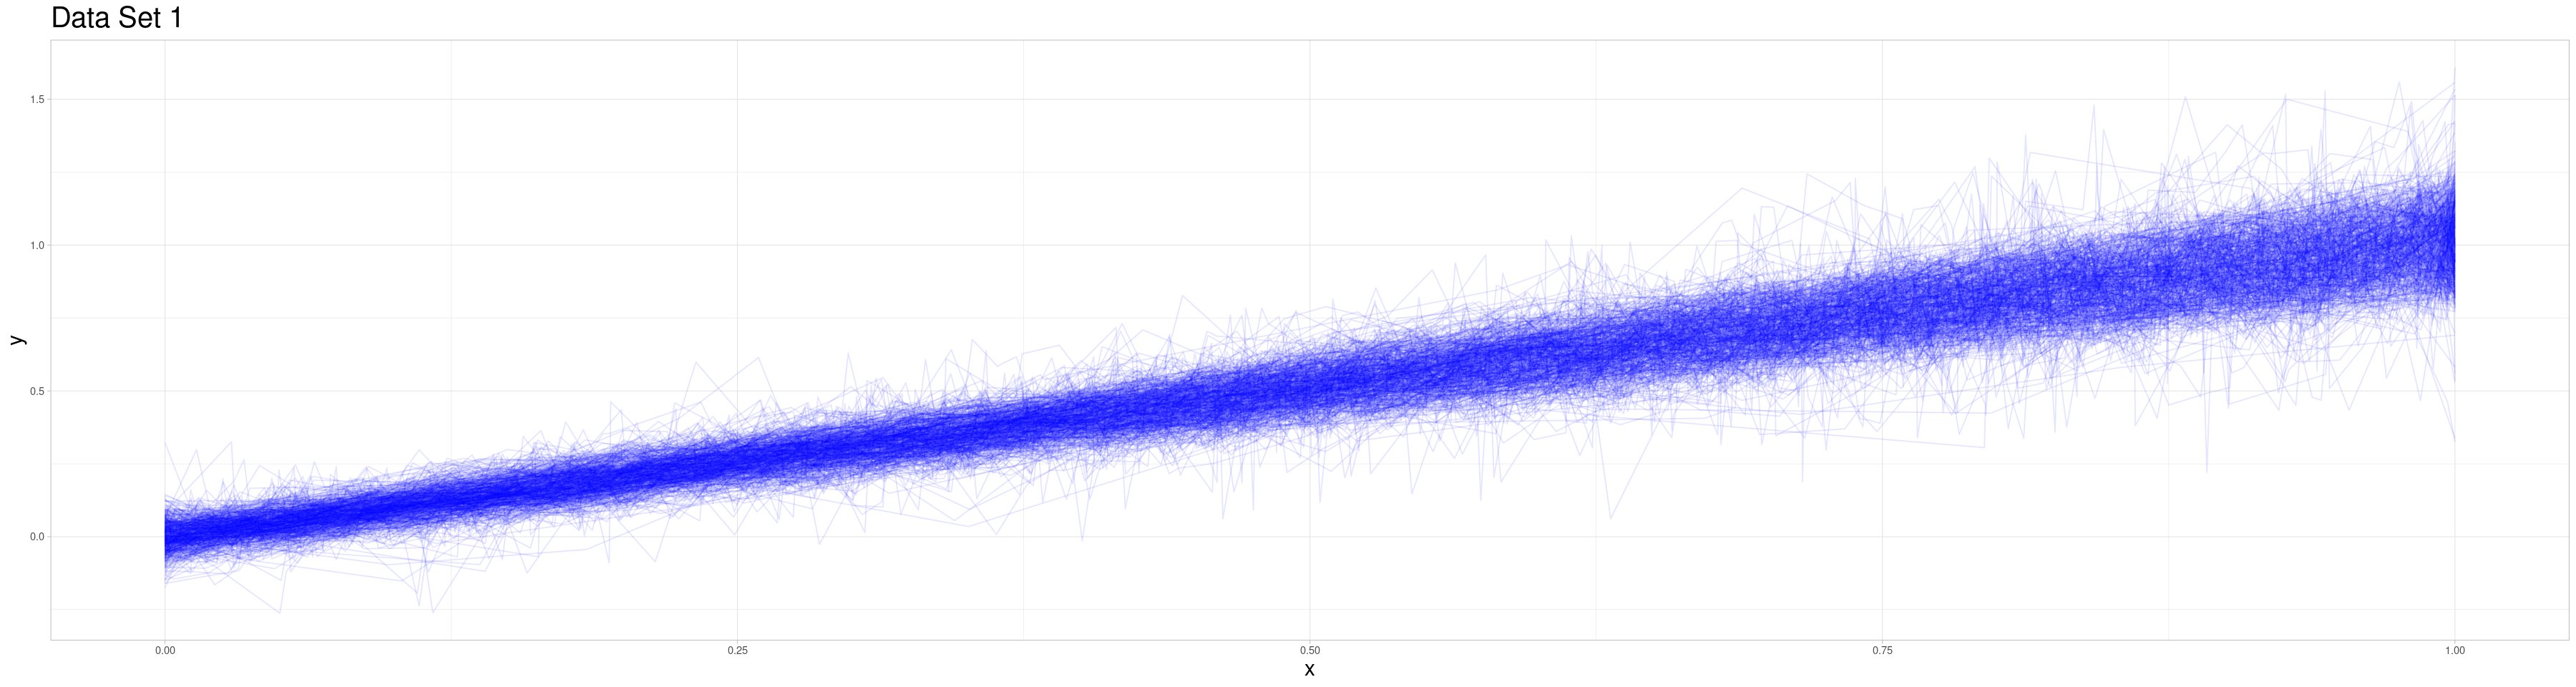

In [13]:
# Data generated, transformed and visualized with functions from auxiliary/generate_set_1.R
# Data set is also saved to ./data/Set_1 and if existent read from there instead
# source("auxiliary/generate_set_1.R")
if(file.exists("./data/Set_1/functional.llo") && 
   file.exists("./data/Set_1/ids.RDS") && 
   file.exists("./data/Set_1/outliers.RDS")){
    data_set_1 <- list(data = readList(file = "./data/Set_1/functional.llo"),
                       ids = readRDS(file = "./data/Set_1/ids.RDS"),
                       outliers = readRDS(file = "./data/Set_1/outliers.RDS"))

} else{
    data_set_1 <- generate_set_1()
}    
                       
tidy_set_1 <- tidify_1(data_set_1$data, data_set_1$ids) 
vis_1(tidy_set_1)           

### Sampling:

### Full Procedure:

Applying these to the original simulated data set yields the following results:

In [38]:
if(Sys.getenv('CI') == "true"){
    num_outliers <- readRDS(file = "data/num_outliers.RDS")
    num_samples <- readRDS(file = "data/num_samples.RDS")
    certainties <- readRDS(file = "data/certainties.RDS")
}

print(which(num_samples == 0))                          
flagged <- which(certainties > 0.5)
original_outliers <- which(outliers == 1)
missed_outliers <- setdiff(original_outliers, flagged)
false_outliers <- setdiff(flagged, original_outliers)

saveRDS(object = list(flagged = flagged,
                      original = original_outliers,
                      missed = missed_outliers,
                      false = false_outliers),
        file = "data/outliers_info.RDS")
saveRDS(object = list(flagged = flagged,
                      original = original_outliers,
                      missed = missed_outliers,
                      false = false_outliers),
        file = "visual/data/outliers_info.RDS")

ERROR: Error in which(num_samples == 0): object 'num_samples' not found


In [ ]:
# Create tibble for visualization

my_tibble <- bind_rows(map(
  .x = 1:n,
  .f = function(i) {
    tibble(
      args = functions[[i]]$args,
      vals = functions[[i]]$vals,
      id = rep(i, times = length(args)),
      cert = rep(certainties[i], times = length(args))
    )
  }
))

saveRDS(object = my_tibble, file = "data/shiny_tibble.RDS")
saveRDS(object = my_tibble, file = "visual/data/shiny_tibble.RDS")

So at least in this simple setting the algorithm identifies nearly all generated outliers and does not classify any regular point as an outlier. This is not always the case and careful choice of the tuning parameters is necessary to ensure a good performance. In the case of other data generating processes, this method can also perform worse, but is applicable in very general settings due to its functional nature.

In [ ]:
if(Sys.getenv('CI') != "true"){suppressWarnings(runApp('visual'))}

## Sources:
---
* Cuevas, A. & Febrero-Bande, M. & Fraiman, R. (2006). On the use of bootstrap for estimating functions with functional data. Computational Statistics & Data Analysis. 51. 1063-1074.
* Febrero-Bande, M. & Galeano, P. & Gonzàlez-Manteiga, W. (2008). Outlier detection in functional data by depth measures, with application to identify abnormal NOx levels. Environmetrics. 19. 331 - 345.
* Gijbels, I. & Nagy, S. (2017). On a General Definition of Depth for Functional Data. Statistical Science. 32. 630-639.